# Experiment 2: Investigating retrieval for different number of topics

## Introduction
A strategy to determine the number of topics, the so called elbow method, is generally used. This strategy is based on topic coherence scores. However, topic coherence scores are measures which was developed to try and determine when the topic makes most sense to humans.

The measure we need to use is one for retrieval. We need to investigate the effect of choosing a different number of topics from that of the elbow method, and compare the retrieval results.

## Experiment description
 - Choose a reference email for a search. In our case it will be one from a newsletter.
 - Fix the corpus and train a number of topic models:
   - Refence topic model trained based on the number of topics as per the elbow method.
   - Topic models with number of topics lower than what the elbow method requires.
   - Topic models with number of topics higher than what the elbow method requires.
 - For each topic model, score the emails in the search space with each of the trained models.
 - Using the reference email, retrieve ranked emails and compare their relative positions to each other.
 

In [1]:
import os
import re
import os
import tempfile
import math
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import json
from pprint import pprint

from tqdm import tqdm

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

import plotly.graph_objects as go


################ Function definitions ###############
# A helper function which loads the json email and returns it as a dictionary
def loadMail(filename):
    with open (filename, "r") as inputFile:
        return json.load(inputFile)
################ End Function definitions ###############


########## Code: Loading Dictionaries #########
def build_dictionaries(subdir, pre_pend_filter = "",  bow_docs_pos = None, dictionary_pos = None, texts_pos = None, filenames = None, limit = 10000, paragraphs = False):
    # This technique requires dictionaries to fit in available memory.
    # It is good for experimenting, but not for general purpose use if lots of data will be processed.
    if(bow_docs_pos == None):
        bow_docs_pos = []
        texts_pos = []
        dictionary_pos = Dictionary()      # Dictionary based on Part of Speech tagging
        filenames = []
    bow_docs_common = []
    texts_common = []
    dictionary_common = Dictionary()   # Dictionary based on common words


    print("Building dictionaries\n")
    #print("Files")
    #print(filenames)

    # Build a dictionary of all the emails
    count = 0
    for root, dirs, files in os.walk(subdir):
        for file in files:
            if not re.search(r'^\.',file):     #Filter out common files created by the OS
                filename = os.path.basename(file)
                if pre_pend_filter == "" or re.match(pre_pend_filter, filename, flags=re.IGNORECASE) != None:
                    email_file = os.path.join(root,file)
                    #new_mail.initMail(email_file)
                    # Build a dictionary and BOW from common token documents

                    #for key, value in developer.items():
                        #print(key, ":", value)
                    email_dict = loadMail(email_file)
                    if paragraphs:
                        paragraph_list = email_dict['body_pos_paragraph_tokens']
                        if len(paragraph_list) > 0:
                            for paragraph in paragraph_list:
                                texts_pos.append(paragraph)
                                dictionary_pos.add_documents([paragraph])
                                bow_docs_pos.append(dictionary_pos.doc2bow(paragraph))
                                #print(email_file)
                                filenames.append(email_file)
                                
                    else:
                        texts_common.append(email_dict['body_tokens'])
                        dictionary_common.add_documents([email_dict['body_tokens']])
                        bow_docs_common.append(dictionary_common.doc2bow(email_dict["body_tokens"]))

                        # Build a specialised POS dictionary and BOW
                        if(email_dict["body_pos_tokens"] != None):
                            texts_pos.append(email_dict["body_pos_tokens"])
                            dictionary_pos.add_documents([email_dict["body_pos_tokens"]])
                            bow_docs_pos.append(dictionary_pos.doc2bow(email_dict["body_pos_tokens"]))
                            filenames.append(email_file)

                    if count == limit:
                        break
                    else:
                        count = count + 1
    print("Finished building dictionaries.\n\n")

    print("Number of documents in the BOW corpus: ",len(bow_docs_common))
    print("Number of documents in the POS corpus: ",len(bow_docs_pos))
    
    return bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,filenames


### Define a helper function to initialise and train the LDA model #####
### The defaults fix some hyperparameters for the LDA model which can be overwritten #####
def build_LDA_model(dictionary, bow_docs, num_topics = 2, 
              chunksize = 2000, 
              passes = 20, 
              iterations = 400, 
              eval_every = None):

    dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=bow_docs,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every)

    return model

#Define a general helper function to take the trained model and plot a wordcloud of the topics.
def plot_wordcloud(model,filename = ''):
    # Extract the topic words and related frequecies.
    topics = model.show_topics(formatted=False)

    # Define a square mask to print the wordcloud.
    x, y = np.ogrid[:500, :500]
    mask = (x - 250) ** 2 + (y - 250) ** 2 > 250 ** 2
    mask = 255 * mask.astype(int)

    # For each topic, extract the word and frequencies, build a wordcloud and display it.
    for topic_nr,topic in zip(range(0,len(topics)),topics):
        topic_words = dict(topic[1])
        cloud = WordCloud(mask=mask,background_color="white").generate_from_frequencies(topic_words)
        plt.figure()
        plt.imshow(cloud)
        plt.axis("off")
        plt.title("Topic nr : " + str(topic_nr + 1))
        plt.show()
        if filename != '':
            topic_filename = filename + '_topic_' + str(topic_nr + 1) + '.png'
            print('Saving: ',topic_filename)
            cloud.to_file(topic_filename)
            
# Helper function to score topics in a range and retain the models in memory
def score_topics(dictionary, bow_docs, texts, start=1, stop=2, step=1, show_progress = True,
                store_models = False, prefix='', num_topics_list = None):

    scores = []
    if num_topics_list is None:
        num_topics_list = list(range(start,stop))   # Build a list of integers from start to stop
        num_topics_subset = num_topics_list[::step] # Pick the subset with step size
    else:
        num_topics_subset = num_topics_list
        
  
        
    with tqdm(total=len(num_topics_subset)) as pbar:
        for num_topics in num_topics_subset:
            model = build_LDA_model(dictionary, bow_docs, num_topics)   #Build the model
            coherence_model_lda = CoherenceModel(model=model, texts = texts, 
                                                 dictionary = dictionary, 
                                                 coherence='c_v')       # Build the coherence model
            coherence_lda = coherence_model_lda.get_coherence()         # Get the coherence score
            scores.append((num_topics, coherence_lda, model))           # Save the coherece score with the associated number of topics
            #if store_models:
            #    with tempfile.NamedTemporaryFile(mode='w+b', prefix=prefix + '_'+str(num_topics)+'_',
            #                                     dir=tmpdir,delete=False) as tmp:
            #        lda.save(tmp.name)
            pbar.update(1)
    
    if store_models:
        tmpdir = tempfile.mkdtemp(prefix = prefix + '_',dir = '.')     #Create a directory to save the models
        score_pairs = {}
        for score in scores:
            num_topics,score,model = score       #Extract the three elements
            with tempfile.NamedTemporaryFile(mode='w+b', prefix=prefix + '_'+str(num_topics)+'_',
                                             dir=tmpdir,delete=False) as tmp:
                    model.save(tmp.name)
            score_pairs[num_topics] = score
        
        with tempfile.NamedTemporaryFile(mode='w', prefix=prefix + '_scores_', suffix = '.json',
                                         dir=tmpdir,delete=False) as tmp:
            print(score_pairs)
            json.dump(score_pairs,tmp)

    return scores

# Helper function which uses plotly to plot the scores
def plot_topic_scores(scores,reference = 0):
    x = []
    y = []
    min = 1
    max = 0

    # Extract the scores as x,y pairs
    for entry in scores:
        x.append(entry[0])
        y.append(entry[1])
        if entry[1] > max:
            max = entry[1]
        if entry[1] < min:
            min = entry[1];

    fig = go.Figure(data=go.Scatter(x=x, y=y,name='Scores'))
    if reference != 0:
        fig.add_scatter(x=[reference]*100, y=np.linspace(min,max,100), name='Reference point')
    fig.show()





def vectorise(topic_scores,nr_topics):
    vector = [0] * nr_topics
    
    for score in topic_scores:
        vector[score[0]] = score[1]
    return vector

def dot_product(vector1,vector2):
    dot_product_sum = 0
    vector1_sum = 0
    vector2_sum = 0
    
    for v1,v2 in zip(vector1,vector2):
        dot_product_sum = dot_product_sum + (v1*v2)
        vector1_sum = vector1_sum + v1*v1
        vector2_sum = vector2_sum + v2*v2
        
    vector_product = round(dot_product_sum,20) / round(math.sqrt(vector1_sum) * math.sqrt(vector2_sum),20)
    return (round(vector_product,5))

def cosine_sim(vector1,vector2):
    vector_product = dot_product(vector1,vector2)
    try:
        angle_radians = math.acos(vector_product)
    except:
        print(vector_product)
        if(vector_product > 1.0):
            vector_product = 1.0
            angle_radians = math.acos(vector_product)
    return math.degrees(angle_radians)

def simialarity(score1,score2,nr_topics):
    vector1 = vectorise(score1,nr_topics)
    vector2 = vectorise(score2,nr_topics)
    angle = cosine_sim(vector1,vector2)
    percentage_simialarity = 100 * (90-angle) / 90
    return percentage_simialarity

def store_scored_models(models_list, path, file_prepend):
    for scored_reference in models_list:
        print(scored_reference)
        filename = path + file_prepend + str(scored_reference[0])
        coherence_score = scored_reference[1]
        model = scored_reference[2]
        print(filename)
        model.save(filename)


def load_scored_model(path,file_prepend, no_topics,texts,dictionary):
    filename = path + file_prepend +str(no_topics)
    print('Loading model:',filename)
    stored_model = LdaModel.load(filename)
    print('Scoring model')
    coherence_model_lda = CoherenceModel(model=stored_model, texts = texts, 
                                                 dictionary = dictionary, 
                                                 coherence='c_v')       # Build the coherence model
    coherence_lda = coherence_model_lda.get_coherence()         # Get the coherence score
    print('Model score:', coherence_lda)
    print()
    return (no_topics,coherence_lda,stored_model)




### Build the reference bag-of-words

For the purposes of the experiment, it will suffice to build a bag-of-words of only allen-p's emails. Any subdirectory can be chosen.

In [2]:
########## Initialisation Section ##########
# Set the location of the directory used for processing
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p') 
#subdir = os.path.join(maildir_path,'allen-p','_sent_mail') 


########## End Initialisation Section ##########


# Build the dictionaries
bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,files = build_dictionaries(subdir,pre_pend_filter = "Full_")



Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  3034
Number of documents in the POS corpus:  3034


### Perform coarse search

A course search is perfomed to determine a rough estimate of the elbow point within the step size.

100%|████████████████████████████████████████| 20/20 [1:39:43<00:00, 299.17s/it]


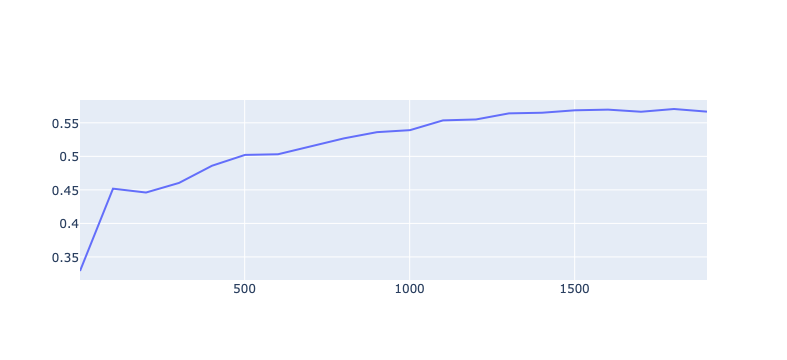

In [3]:
pos_scores_coarse = score_topics(dictionary_pos, bow_docs_pos, texts_pos, start = 1, step = 100, stop = 2000)
    
plot_topic_scores(pos_scores_coarse)        

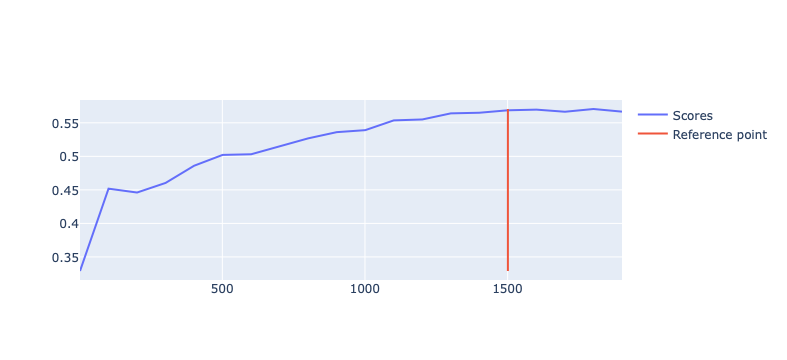

In [4]:
plot_topic_scores(pos_scores_coarse,reference=1501)

### Perform medium search

Based on the above plot, a medium granualarity search is conducted around the chosen point.

100%|████████████████████████████████████████| 10/10 [1:30:09<00:00, 540.98s/it]


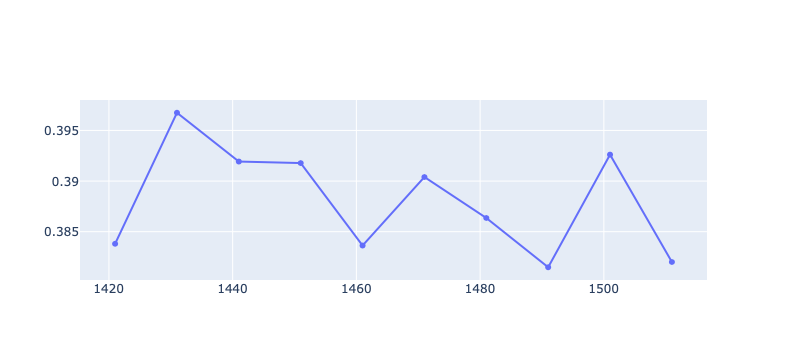

In [6]:
pos_scores_medium = score_topics(dictionary_common, bow_docs_common, texts_common, start = 1421, step = 10, stop = 1521)
    
plot_topic_scores(pos_scores_medium)        

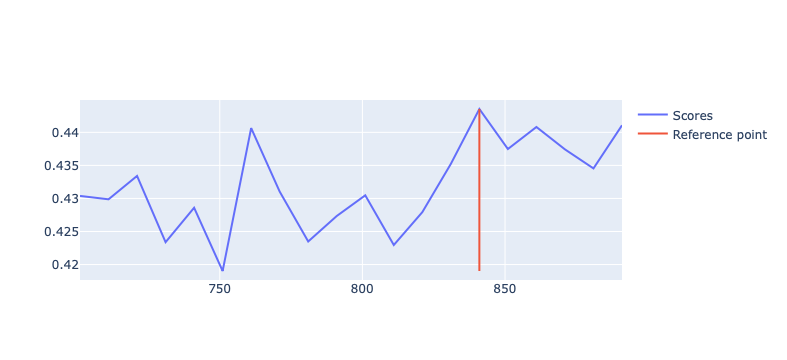

In [27]:
plot_topic_scores(pos_scores_medium,reference=841)

### Perform a fine search

Based on the above plot, a fine granualarity search is conducted around the chosen point.

100%|████████████████████████████████████████| 20/20 [2:43:12<00:00, 489.60s/it]


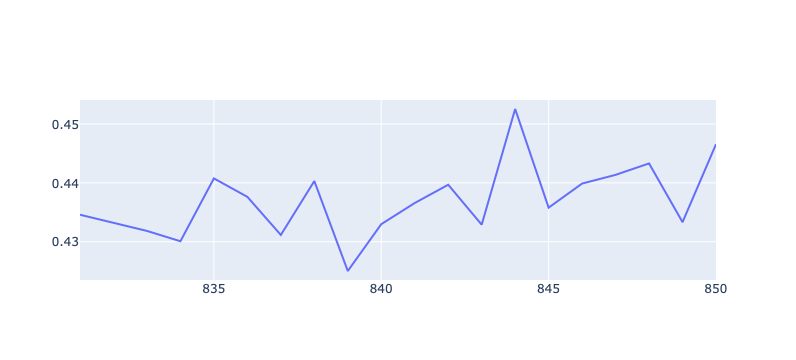

In [25]:
pos_scores_fine = score_topics(dictionary_common, bow_docs_common, texts_common, start = 831, step = 1, stop = 851)
    
plot_topic_scores(pos_scores_fine)        

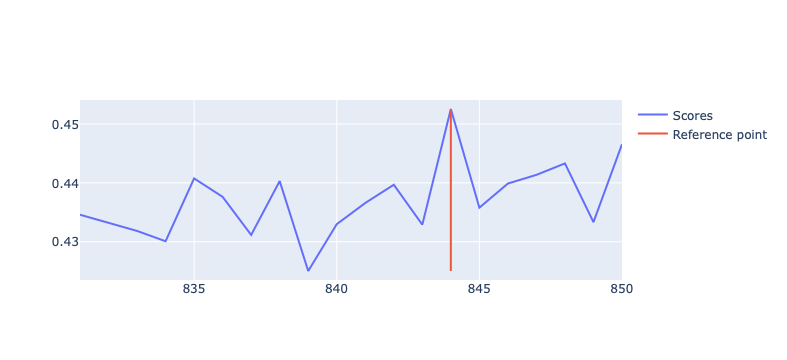

In [26]:
plot_topic_scores(pos_scores_fine,reference=844)

### Train the models

With the reference for the elbow now determined, we train a number of models around the reference. Allow for one more and one less, i.e. very close. Then two further off, and then is way further off. A total of 7 models are therefore trained.

In [7]:
reference_nr_topics = 1501
intervals = [1,2,3,4,10,20,30,40]

# Build a list of number of topics, starting with reference, ref+-1, ref+-2 etc.
num_topics_list = [reference_nr_topics] 
for interval in intervals:
    num_topics_list.append(reference_nr_topics + interval)
    num_topics_list.append(reference_nr_topics - interval)
num_topics_list.sort()
# number of topics list is now sorted, with the reference no topics in the middel

#reference_nr_topics_index = math.ceil(len(num_topics_list) / 2)

# Now train all the models with ref_num_topics.
reference_models_scored = score_topics(dictionary_pos, bow_docs_pos, texts_pos,num_topics_list = num_topics_list)

100%|████████████████████████████████████████| 17/17 [1:59:55<00:00, 423.27s/it]


In [8]:
low_topic_model = score_topics(dictionary_pos, bow_docs_pos, texts_pos,start = 20, stop = 22)

100%|█████████████████████████████████████████████| 2/2 [01:01<00:00, 30.70s/it]


In [31]:

reference_models_scored.insert(0,low_topic_model[0])
reference_models_scored

[(20, 0.3937782951549017, <gensim.models.ldamodel.LdaModel at 0x11f597f10>),
 (1461, 0.5663810705345167, <gensim.models.ldamodel.LdaModel at 0x11ea64df0>),
 (1471, 0.5729047796249177, <gensim.models.ldamodel.LdaModel at 0x127bafeb0>),
 (1481, 0.5702301958733804, <gensim.models.ldamodel.LdaModel at 0x12479e040>),
 (1491, 0.5624055068285494, <gensim.models.ldamodel.LdaModel at 0x12065cfa0>),
 (1497, 0.5698386254887, <gensim.models.ldamodel.LdaModel at 0x123877040>),
 (1498, 0.5688884837877433, <gensim.models.ldamodel.LdaModel at 0x124920df0>),
 (1499, 0.5689328353164028, <gensim.models.ldamodel.LdaModel at 0x11f094460>),
 (1500, 0.5689190671934387, <gensim.models.ldamodel.LdaModel at 0x11ffd7040>),
 (1501, 0.5694647793433656, <gensim.models.ldamodel.LdaModel at 0x11d8047c0>),
 (1502, 0.5687414786983986, <gensim.models.ldamodel.LdaModel at 0x11ef65bb0>),
 (1503, 0.5699395366862922, <gensim.models.ldamodel.LdaModel at 0x11d7a28e0>),
 (1504, 0.564843401296409, <gensim.models.ldamodel.LdaMod

In [32]:
#maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
# Extract a single email, and score it as the reference email for comparison later.
query_email_filepath = os.path.join(maildir_path,'allen-p','all_documents')
query_email_filename = os.path.join(query_email_filepath,'Full_1.json')

query_email_bow_pos = []
query_email_texts_pos = []

# Load the query email and convert it to tokens.
query_email = loadMail(query_email_filename)
#if(query_email["body_tokens"] != None):
#    query_email_bow_pos.append(dictionary_pos.doc2bow(query_email["body_tokens"]))
if(query_email["body_pos_tokens"] != None):
    query_email_bow_pos.append(dictionary_pos.doc2bow(query_email["body_pos_tokens"]))

    
# Score the query email under each model, and save the score in query_email_scores
query_email_scores = []
for model in reference_models_scored:
    query_email_score = model[2][query_email_bow_pos[0]]
    query_email_scores.append(query_email_score)


In [33]:
# Determine how many models we have to work with.
no_models = len(reference_models_scored)


# For each model, we create an email_similarity_scores list, and a rankings dictionary to populate later.
email_simialarity_scores = [] 
scores_dictionaries = []
for index in range(0,no_models):
    new_list = []
    new_dict_rankings = {}
    email_simialarity_scores.append(new_list)
    scores_dictionaries.append(new_dict_rankings)

# Iterate over each model, and each email; score the email, and find its simialarity to the query email. and save the cosine simialarity and position of the mail.
email_nr = 0
with tqdm(total=len(bow_docs_pos)) as pbar:
    for bow in bow_docs_pos:
        email_nr = email_nr + 1
        #print(email_nr)
            
        for index in range(0,no_models):
            model = reference_models_scored[index][2]     # Extract the model
            document_score = model[bow]                   # Score the email

            if len(document_score) == 0:
                sim = 0.0
            else:
                sim = simialarity(query_email_scores[index],document_score,reference_models_scored[index][0])  #Calculate simialarity to query email
            email_simialarity_scores[index].append(sim)   # Store the simialarity in order of scoring
            score_dictionary = scores_dictionaries[index] # Extract the dictionary for this model
            score_dictionary[email_nr] = sim              # Store similariy in dictionary, with key posisition in scoring
        pbar.update(1)


100%|███████████████████████████████████████| 3034/3034 [49:49<00:00,  1.02it/s]


In [34]:
# For each dictionary, sort the dictionary according to its similarity scores.
ranked_dictionaries = []
for dictionary in scores_dictionaries:
    ranked_emails = sorted(dictionary.items(),key=lambda x: x[1], reverse = True)
    ranked_dictionaries.append(ranked_emails)

In [38]:
# Iterate over each model, and each email; score the email, and find its simialarity to the query email. and save the cosine simialarity and position of the mail.


top_50_lists = []

for i in range(0,len(ranked_dictionaries)):
    print('Index: ',i)
    top_50_list = []
    for j in range(0,50):
        ranked_dictionary = ranked_dictionaries[i][j]
        print(ranked_dictionary[0], ranked_dictionary[1])
        if ranked_dictionary[1] !=0:
            #print(ranked_dictionary[0], ranked_dictionary[1])
            top_50_list.append(ranked_dictionary[0])
    top_50_lists.append(top_50_list)
    print()
    
print(top_50_lists)

Index:  0
28 100.0
45 100.0
164 100.0
199 100.0
361 100.0
445 100.0
464 100.0
536 100.0
633 100.0
665 100.0
787 100.0
802 100.0
804 100.0
922 100.0
1161 100.0
1163 100.0
1222 100.0
1384 100.0
1437 100.0
1598 100.0
1657 100.0
1818 100.0
1866 100.0
2039 100.0
2229 100.0
2455 100.0
2493 100.0
2578 100.0
2652 100.0
2971 100.0
3003 100.0
1511 99.14587854190661
2218 99.14587854190661
2818 99.14587854190661
111 98.15483602232747
628 97.70451041728388
1746 97.70451041728388
2337 97.70451041728388
2413 97.70451041728388
91 97.60089092092468
634 91.21784009800633
1393 91.21784009800633
2049 91.21784009800633
2679 91.21784009800633
1011 84.45346617147185
221 84.35634223464032
1183 76.27884860859307
2567 73.61087730838106
1316 73.60929667093718
2204 73.60929667093718

Index:  1
45 100.0
536 100.0
2971 100.0
396 26.06189607055206
1931 13.85957211194221
2630 13.76113538326436
630 13.650352545173044
142 13.507048758568187
1609 13.1900721374483
940 7.840680984017609
221 7.387351430581061
399 6.2783303

In [181]:
# The reference index is the middel of the list where the model was scored on the reference topic score.
reference_index = 9
reference_result = top_50_lists[reference_index]
reference_topic_score = (reference_models_scored[reference_index])[1]

# Extract higher and lower topic scores c_v to determine higher or lower

def topic_scores_movement(reference_topic_score):
    relative_topic_scores = []
    for model in reference_models_scored:
        if model[1] > reference_topic_score:
            relative_topic_scores.append("Higher")
        elif model[1] == reference_topic_score:
            relative_topic_scores.append("Equal")
        elif model[1] < reference_topic_score:
            relative_topic_scores.append("Lower")
    return relative_topic_scores


def movement_stats(intersection_data):
    # Compute some position movement
    
    stats = {}
    
    max_pos_movement = 0
    max_neg_movement = 0
    pos_sum = 0
    neg_sum = 0
    pos_cnt = 0
    neg_cnt = 0
    overall_cnt = 0;

    # Run through the movemenet data and count
    for rank in intersection_data:
        overall_cnt = overall_cnt + 1
        movement = rank[3]
        
        if (movement > 0):
            if movement > max_pos_movement:
                max_pos_movement = movement
            pos_sum = pos_sum + movement
            pos_cnt = pos_cnt + 1
        
        elif (movement < 0):
            if movement < max_neg_movement:
                max_neg_movement = movement
            neg_sum = neg_sum + movement
            neg_cnt = neg_cnt + 1
    #Compute the stats
    stats["max_pos_movement"] = max_pos_movement
    stats["max_neg_movement"] = max_neg_movement
    if (pos_cnt == 0):
        stats["avg_pos_movement"] = 0
    else :
        stats["avg_pos_movement"] = pos_sum / pos_cnt
    if (neg_cnt == 0):
        stats["avg_neg_movement"] = 0
    else:    
        stats["avg_neg_movement"] = neg_sum / neg_cnt
    if(overall_cnt == 0):
        stats["avg_overall_movement"] = 0
    else:
        stats["avg_overall_movement"] = (pos_sum + neg_sum) / overall_cnt
    
    return stats


def intersection(list1, list2):
    # Determine the intersection
    intersection_list = list(set(list1) & set(list2))
    
    intersection = []
    # Compute and store the relative movement in the intersection 
    # Positive movement is upward, and negative movement is downward in the list     
    for mail_nr in intersection_list:
        position1 = list1.index(mail_nr)
        position2 = list2.index(mail_nr)
        movement = position1 - position2
        position_data = (mail_nr,position1,position2,movement)
        intersection.append(position_data)
    return intersection


def compare_lists(top_50_lists, relative_topic_scores, reference_result):
    top_50_comparison_data = []

    for index in range(0,len(top_50_lists)):
        #Calculate the intersection and associated movement stats
        intersection_list = intersection(reference_result,top_50_lists[index])
        stats = movement_stats(intersection_list)
        #Store the results in a dictionary for later reference
        comparison = {}
        comparison["no_topics"] = reference_models_scored[index][0]
        comparison["score"] = reference_models_scored[index][1]
        comparison["intersection_list"] = intersection_list
        comparison["intersection_size"] = len(intersection_list)

        comparison["max_pos_movement"] = stats["max_pos_movement"]
        comparison["max_neg_movement"] = stats["max_neg_movement"]
        comparison["avg_pos_movement"]  = stats["avg_pos_movement"] 
        comparison["avg_neg_movement"] = stats["avg_neg_movement"] 
        comparison["avg_overall_movement"] = stats["avg_overall_movement"]
        comparison["topic_score_movement"] = relative_topic_scores[index]

        top_50_comparison_data.append(comparison)

    return top_50_comparison_data
    #print(index , ' ' * len(intersection_list),len(intersection_list))
    
relative_topic_scores = topic_scores_movement(reference_topic_score)

top_50_comparison_data = compare_lists(top_50_lists, relative_topic_scores, reference_result)
#print(top_50_comparison_data)
        

In [207]:
for model in top_50_comparison_data:
    print(model['no_topics'] , model['intersection_size'])

20 3
1461 23
1471 22
1481 28
1491 29
1497 28
1498 13
1499 21
1500 7
1501 35
1502 13
1503 18
1504 30
1505 13
1511 21
1521 17
1531 11
1541 14


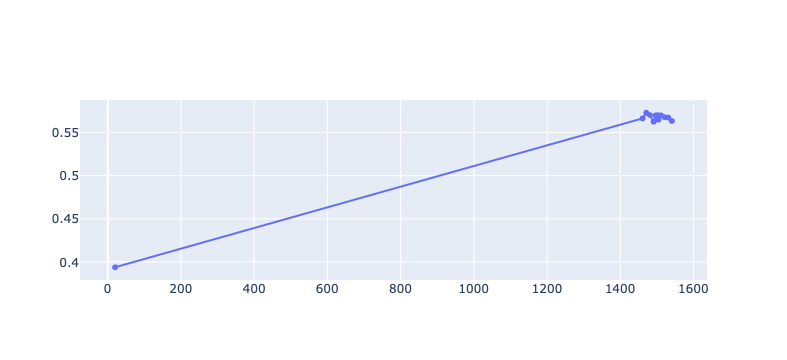

In [198]:
plot_topic_scores(reference_models_scored)



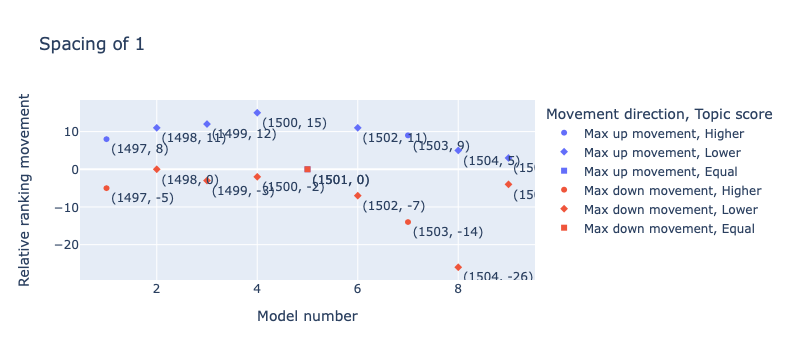

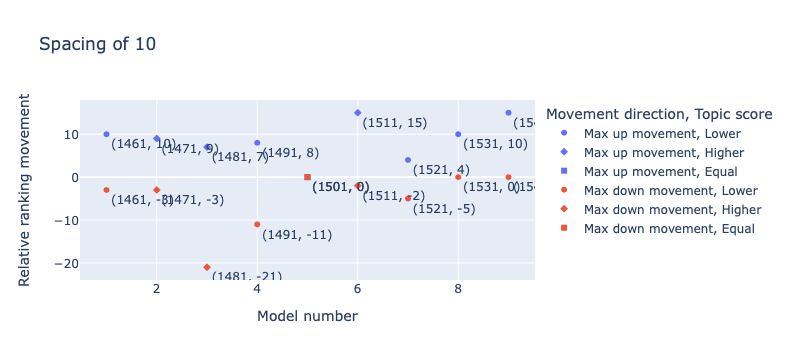

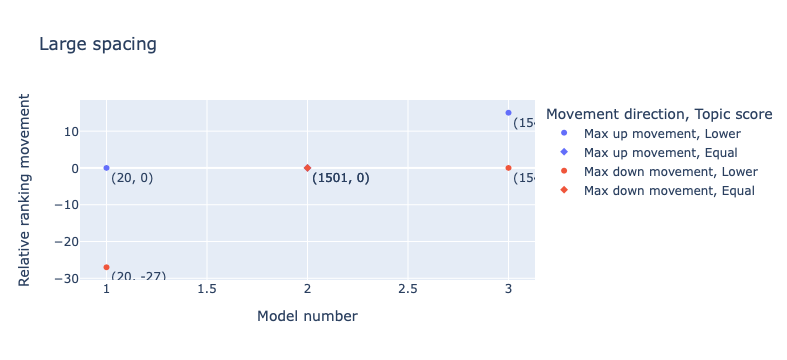

In [196]:
import plotly.express as px
small_step_results = top_50_comparison_data[reference_index - 4:reference_index] + top_50_comparison_data[reference_index:reference_index + 1] + top_50_comparison_data[reference_index + 1:reference_index + 5]
medium_step_results = top_50_comparison_data[reference_index - 8:reference_index - 4] + top_50_comparison_data[reference_index:reference_index + 1] + top_50_comparison_data[reference_index + 5:reference_index + 9]
large_step_results = top_50_comparison_data[reference_index - 9:reference_index - 8]  + top_50_comparison_data[reference_index:reference_index + 1] + top_50_comparison_data[reference_index + 8:reference_index + 9]

######## Max movement data #########
x = []
y = []
text = []
category = []
rel_topic_score = []

for model,index in zip(small_step_results,range(1,len(small_step_results) + 1)):
    #print(model["no_topics"])

    x.append(index)
    y.append(model["max_pos_movement"])
    text.append((model["no_topics"],model["max_pos_movement"]))
    category.append('Max up movement')
    rel_topic_score.append(model["topic_score_movement"])
    
    x.append(index)
    y.append(model["max_neg_movement"])
    text.append((model["no_topics"],model["max_neg_movement"]))
    category.append('Max down movement')
    rel_topic_score.append(model["topic_score_movement"])


fig = px.scatter(x=x, y=y,text = text,color = category, symbol = rel_topic_score,
                labels = {
                    "x" : "Model number",
                    "y" : "Relative ranking movement",
                    "color" : "Movement direction",
                    "symbol" : "Topic score"
                         },
                title = "Spacing of 1")
fig.update_traces(textposition="bottom right")
fig.show()





x = []
y = []
text = []
category = []
rel_topic_score = []

for model,index in zip(medium_step_results,range(1,len(medium_step_results) + 1)):
    #print(model["no_topics"])

    x.append(index)
    y.append(model["max_pos_movement"])
    text.append((model["no_topics"],model["max_pos_movement"]))
    category.append('Max up movement')
    rel_topic_score.append(model["topic_score_movement"])
    
    x.append(index)
    y.append(model["max_neg_movement"])
    text.append((model["no_topics"],model["max_neg_movement"]))
    category.append('Max down movement')
    rel_topic_score.append(model["topic_score_movement"])

    


fig = px.scatter(x=x, y=y,text = text,color = category, symbol = rel_topic_score,
                labels = {
                    "x" : "Model number",
                    "y" : "Relative ranking movement",
                    "color" : "Movement direction",
                    "symbol" : "Topic score"
                         },
                title = "Spacing of 10")
fig.update_traces(textposition="bottom right")
fig.show()





x = []
y = []
text = []
category = []
rel_topic_score = []

for model,index in zip(large_step_results,range(1,len(large_step_results) + 1)):
    #print(model["no_topics"])

    x.append(index)
    y.append(model["max_pos_movement"])
    text.append((model["no_topics"],model["max_pos_movement"]))
    category.append('Max up movement') 
    rel_topic_score.append(model["topic_score_movement"])
    
    x.append(index)
    y.append(model["max_neg_movement"])
    text.append((model["no_topics"],model["max_neg_movement"]))
    category.append('Max down movement') 
    rel_topic_score.append(model["topic_score_movement"])

fig = px.scatter(x=x, y=y,text = text,color = category, symbol = rel_topic_score,
                labels = {
                    "x" : "Model number",
                    "y" : "Relative ranking movement",
                    "color" : "Movement direction",
                    "symbol" : "Topic score"
                         },
                title = "Large spacing")
fig.update_traces(textposition="bottom right")
fig.show()

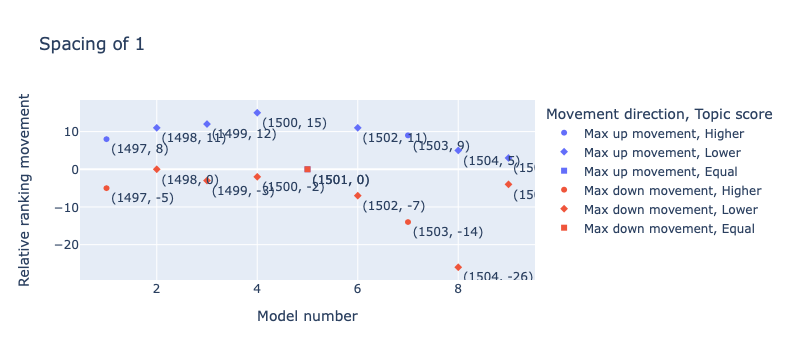

In [208]:
### Testing. To be deleted.



import plotly.express as px
small_step_results = top_50_comparison_data[reference_index - 4:reference_index] + top_50_comparison_data[reference_index:reference_index + 1] + top_50_comparison_data[reference_index + 1:reference_index + 5]
medium_step_results = top_50_comparison_data[reference_index - 8:reference_index - 4] + top_50_comparison_data[reference_index:reference_index + 1] + top_50_comparison_data[reference_index + 5:reference_index + 9]
large_step_results = top_50_comparison_data[reference_index - 9:reference_index - 8]  + top_50_comparison_data[reference_index:reference_index + 1] + top_50_comparison_data[reference_index + 8:reference_index + 9]

######## Max movement data #########
x = []
y = []
text = []
category = []
rel_topic_score = []

for model,index in zip(small_step_results,range(1,len(small_step_results) + 1)):
    #print(model["no_topics"])

    x.append(index)
    y.append(model["max_pos_movement"])
    text.append((model["no_topics"],model["max_pos_movement"]))
    category.append('Max up movement')
    rel_topic_score.append(model["topic_score_movement"])
    
    x.append(index)
    y.append(model["max_neg_movement"])
    text.append((model["no_topics"],model["max_neg_movement"]))
    category.append('Max down movement')
    rel_topic_score.append(model["topic_score_movement"])


fig = px.scatter(x=x, y=y,text = text,color = category, symbol = rel_topic_score,
                labels = {
                    "x" : "Model number",
                    "y" : "Relative ranking movement",
                    "color" : "Movement direction",
                    "symbol" : "Topic score"
                         },
                title = "Spacing of 1")
fig.update_traces(textposition="bottom right")
fig.show()




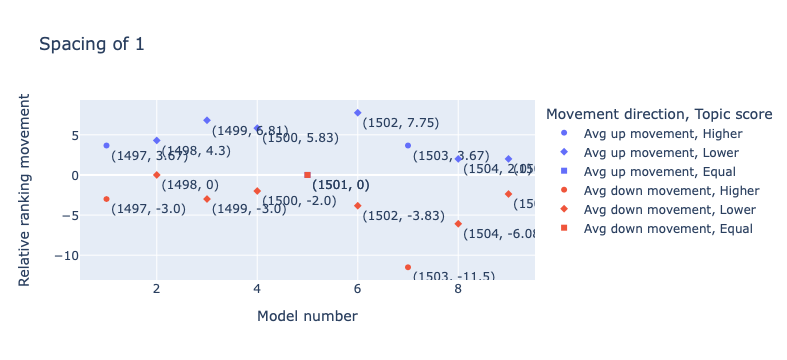

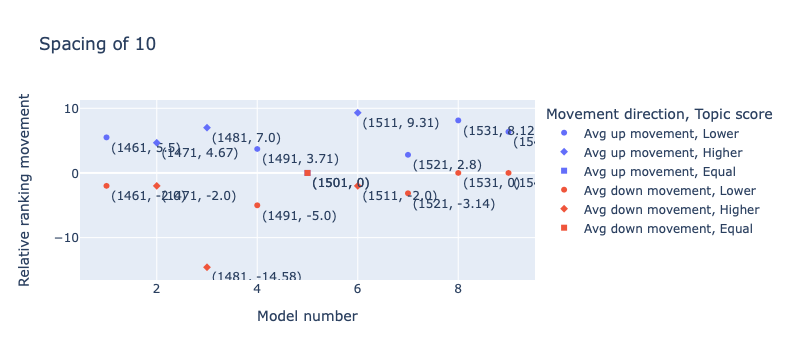

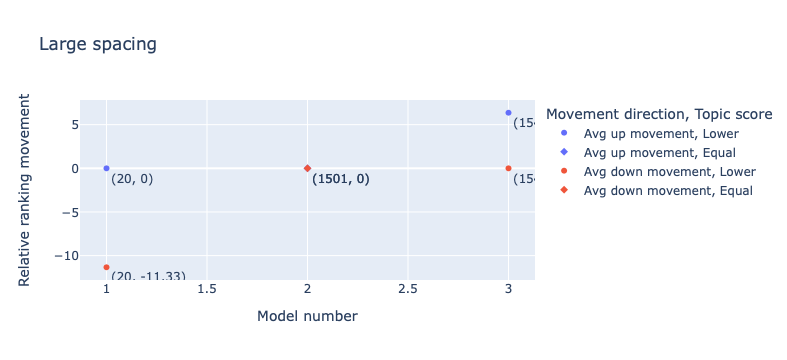

In [197]:
######## Avg pos and neg movement data #########
x = []
y = []
text = []
category = []
rel_topic_score = []

for model,index in zip(small_step_results,range(1,len(small_step_results) + 1)):
    #print(model["no_topics"])

    x.append(index)
    y.append(model["avg_pos_movement"])
    text.append((model["no_topics"],round(model["avg_pos_movement"],2)))
    category.append('Avg up movement')
    rel_topic_score.append(model["topic_score_movement"])
    
    x.append(index)
    y.append(model["avg_neg_movement"])
    text.append((model["no_topics"],round(model["avg_neg_movement"],2)))
    category.append('Avg down movement') 
    rel_topic_score.append(model["topic_score_movement"])

fig = px.scatter(x=x, y=y,text = text,color = category, symbol = rel_topic_score,
                labels = {
                    "x" : "Model number",
                    "y" : "Relative ranking movement",
                    "color" : "Movement direction",
                    "symbol" : "Topic score"
                         },
                title = "Spacing of 1")
fig.update_traces(textposition="bottom right")
fig.show()


x = []
y = []
text = []
category = []
rel_topic_score = []

for model,index in zip(medium_step_results,range(1,len(medium_step_results) + 1)):
    #print(model["no_topics"])

    x.append(index)
    y.append(model["avg_pos_movement"])
    text.append((model["no_topics"],round(model["avg_pos_movement"],2)))
    category.append('Avg up movement')
    rel_topic_score.append(model["topic_score_movement"])
    
    x.append(index)
    y.append(model["avg_neg_movement"])
    text.append((model["no_topics"],round(model["avg_neg_movement"],2)))
    category.append('Avg down movement')
    rel_topic_score.append(model["topic_score_movement"])


fig = px.scatter(x=x, y=y,text = text,color = category,  symbol = rel_topic_score,
                labels = {
                    "x" : "Model number",
                    "y" : "Relative ranking movement",
                    "color" : "Movement direction",
                    "symbol" : "Topic score"
                         },
                title = "Spacing of 10")
fig.update_traces(textposition="bottom right")
fig.show()

x = []
y = []
text = []
category = []
rel_topic_score = []

for model,index in zip(large_step_results,range(1,len(large_step_results) + 1)):
    #print(model["no_topics"])

    x.append(index)
    y.append(model["avg_pos_movement"])
    text.append((model["no_topics"],round(model["avg_pos_movement"],2)))
    category.append('Avg up movement')
    rel_topic_score.append(model["topic_score_movement"])
    
    x.append(index)
    y.append(model["avg_neg_movement"])
    text.append((model["no_topics"],round(model["avg_neg_movement"],2)))
    category.append('Avg down movement')
    rel_topic_score.append(model["topic_score_movement"])


fig = px.scatter(x=x, y=y,text = text,color = category,  symbol = rel_topic_score,
                labels = {
                    "x" : "Model number",
                    "y" : "Relative ranking movement",
                    "color" : "Movement direction",
                    "symbol" : "Topic score"
                         },
                title = "Large spacing")
fig.update_traces(textposition="bottom right")
fig.show()

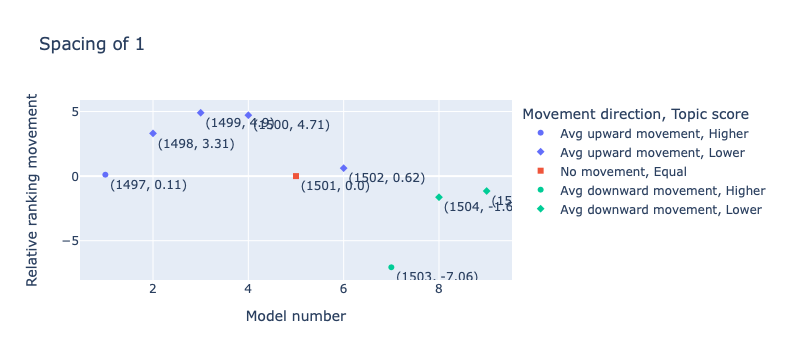

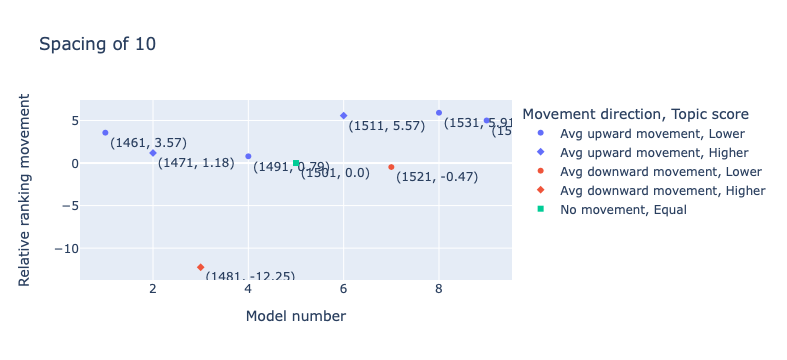

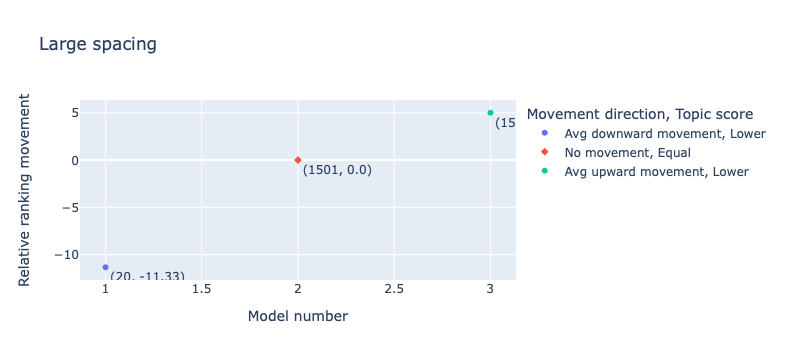

In [195]:
######## Avg overall movement data #########
x = []
y = []
text = []
category = []
rel_topic_score = []

for model,index in zip(small_step_results,range(1,len(small_step_results) + 1)):
    #print(model["no_topics"])

    x.append(index)
    y.append(model["avg_overall_movement"])
    text.append((model["no_topics"],round(model["avg_overall_movement"],2)))
    if (model["avg_overall_movement"] == 0):
        category.append('No movement')
    elif(model["avg_overall_movement"] > 0):
        category.append('Avg upward movement')
    elif(model["avg_overall_movement"] < 0):
        category.append('Avg downward movement')
    rel_topic_score.append(model["topic_score_movement"])
    
fig = px.scatter(x=x, y=y,text = text,color = category,  symbol = rel_topic_score,
                labels = {
                    "x" : "Model number",
                    "y" : "Relative ranking movement",
                    "color" : "Movement direction",
                    "symbol" : "Topic score"
                         },
                title = "Spacing of 1")
fig.update_traces(textposition="bottom right")
fig.show()


x = []
y = []
text = []
category = []
rel_topic_score = []

for model,index in zip(medium_step_results,range(1,len(medium_step_results) + 1)):
    #print(model["no_topics"])

    x.append(index)
    y.append(model["avg_overall_movement"])
    text.append((model["no_topics"],round(model["avg_overall_movement"],2)))
    if (model["avg_overall_movement"] == 0):
        category.append('No movement')
    elif(model["avg_overall_movement"] > 0):
        category.append('Avg upward movement')
    elif(model["avg_overall_movement"] < 0):
        category.append('Avg downward movement')
    rel_topic_score.append(model["topic_score_movement"])
    
fig = px.scatter(x=x, y=y,text = text,color = category,  symbol = rel_topic_score,
                labels = {
                    "x" : "Model number",
                    "y" : "Relative ranking movement",
                    "color" : "Movement direction",
                    "symbol" : "Topic score"
                         },
                title = "Spacing of 10")
fig.update_traces(textposition="bottom right")
fig.show()



x = []
y = []
text = []
category = []
rel_topic_score = []

for model,index in zip(large_step_results,range(1,len(large_step_results) + 1)):
    #print(model["no_topics"])

    x.append(index)
    y.append(model["avg_overall_movement"])
    text.append((model["no_topics"],round(model["avg_overall_movement"],2)))
    if (model["avg_overall_movement"] == 0):
        category.append('No movement')
    elif(model["avg_overall_movement"] > 0):
        category.append('Avg upward movement')
    elif(model["avg_overall_movement"] < 0):
        category.append('Avg downward movement')
    rel_topic_score.append(model["topic_score_movement"])
    
fig = px.scatter(x=x, y=y,text = text,color = category,  symbol = rel_topic_score,
                labels = {
                    "x" : "Model number",
                    "y" : "Relative ranking movement",
                    "color" : "Movement direction",
                    "symbol" : "Topic score"
                         },
                title = "Large spacing")
fig.update_traces(textposition="bottom right")
fig.show()




In [215]:
reference_models_scored[0][2].save('ref_model_' + str(reference_models_scored[0][0]))


In [220]:
for reference in reference_models_scored:
    print(reference)
    filename = 'stored_models_experiment2/reference_model_' + str(reference[0])
    coherence_score = reference[1]
    model = reference[2]
    print(filename)
    model.save(filename)

(20, 0.3937782951549017, <gensim.models.ldamodel.LdaModel object at 0x11f597f10>)
stored_models_experiment2/reference_model_20
(1461, 0.5663810705345167, <gensim.models.ldamodel.LdaModel object at 0x11ea64df0>)
stored_models_experiment2/reference_model_1461
(1471, 0.5729047796249177, <gensim.models.ldamodel.LdaModel object at 0x127bafeb0>)
stored_models_experiment2/reference_model_1471
(1481, 0.5702301958733804, <gensim.models.ldamodel.LdaModel object at 0x12479e040>)
stored_models_experiment2/reference_model_1481
(1491, 0.5624055068285494, <gensim.models.ldamodel.LdaModel object at 0x12065cfa0>)
stored_models_experiment2/reference_model_1491
(1497, 0.5698386254887, <gensim.models.ldamodel.LdaModel object at 0x123877040>)
stored_models_experiment2/reference_model_1497
(1498, 0.5688884837877433, <gensim.models.ldamodel.LdaModel object at 0x124920df0>)
stored_models_experiment2/reference_model_1498
(1499, 0.5689328353164028, <gensim.models.ldamodel.LdaModel object at 0x11f094460>)
stored